# Imports

In [ ]:
pip install -U seaborn-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing some basic libraries we will use
import numpy as np                          # Mathematical library with support for matrix manipulation akin to MATLAB
import matplotlib.pyplot as plt             # Plotting library similar to MATLAB's "plot"
from IPython.display import clear_output    # Useful to animate plots
from scipy.ndimage import gaussian_filter1d # Useful for smoothing performance curves
import seaborn as sns                       # Prettier plots
import seaborn_image                        # Prettier heatmaps

# Grid World

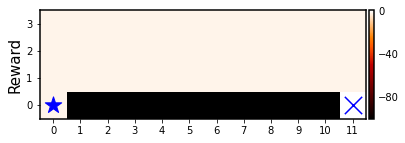

In [ ]:
# This class helps us create a "gridworld" object that responds to your actions by updating your position & giving you rewards
# For e.g. env = gridworld() creates an object called "env" whose functions can be invoked e.g. by env.move(action)
# Instances of the object "env" itself are referred to as "self" within function definitions
class gridworld:

  # Initialization 
  def __init__(self):
    self.S = [0,0]                                  # Starting position 'S' in the gridworld
    self.R = -np.ones([12,4])                       # Cost of -1 everytime you move in the 12x4 grid
    self.goal_x = 11                                # x coord of goal
    self.goal_y = 0                                 # y coord of goal
    self.R[1:11,0] = -100                           # Cost of -100 if you fall off the cliff   
    self.R[self.goal_x, self.goal_y] = 100          # Reward of 100 if you reach the goal
    self.stored_reward = []                         # Stores reward earned throughout training

  # Plot gridworld & current position
  def plot(self,ax):
    ax.invert_yaxis()
    ax.scatter(self.S[0],self.S[1],300,c='blue',marker='*')                                             # Agent marker
    ax.scatter(self.goal_x, self.goal_y,300, c='blue', marker='x')                                      # Goal marker
    g = seaborn_image.imshow(self.R.T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1,ax=ax)    # Reward heat map
    ax.set_ylabel('Reward')
    ax.set_xticks(range(12))
    ax.set_yticks(range(4))

  # Change the location of the goal/reward
  def update_goal(self, x, y):
    self.R[self.goal_x, self.goal_y] = -1    # Remove previous reward
    self.goal_x = x                          # Update goal x coord
    self.goal_y = y                          # Update goal y coord
    self.R[self.goal_x, self.goal_y] = 100   # Add reward to new goal location

  # Move based on action inputs
  def move(self, action):
    # Previous position 'Sprev'
    Sprev = self.S
    # Try moving to new position 'Scurr'
    if action == 0:    
      Scurr = [self.S[0]-1,self.S[1]]     # left
    elif action == 1:  
      Scurr = [self.S[0]+1,self.S[1]]     # right
    elif action == 2:  
      Scurr = [self.S[0],self.S[1]-1]     # down
    elif action == 3:  
      Scurr = [self.S[0],self.S[1]+1]     # up  

    # Reset to start if you fall off the cliff
    if Scurr[0]>0 and Scurr[0]<11 and Scurr[1]==0:
      Rcurr = -100
      Scurr = [0,0]
    # Reset to start if you reach the goal
    elif Scurr[0]==self.goal_x and Scurr[1]==self.goal_y:
      Rcurr = 100
      Scurr = [0,0]
    # No movement, cost of -5 if you hit a wall
    elif Scurr[0]<0 or Scurr[0]>11 or Scurr[1]<0 or Scurr[1]>3:
      Scurr = Sprev
      Rcurr = -5
    # Any other movement costs -1
    else:
      Rcurr = -1

    # Append reward received
    self.stored_reward.append(Rcurr)

    # Final new position 'Scurr'
    self.S = Scurr

    # Return old, new positions & reward at new position
    return Sprev, Scurr, Rcurr
  
  def get_stored_reward(self):
    return self.stored_reward

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
env = gridworld()
env.plot(ax)
plt.show()

# Actor-Critic Agent

In [ ]:
# Actor-Critic agent object, which stores and updates policy and value functions to navigate the gridworld.
# An agent can be one of 3 types: 1) Basic, no latent cause inference; 2) Change-point; 3) Continual learning
class agent:

  # Initialization
  def __init__(self, form, eta_v, eta_p, beta): 
    self.form = form      # Type of agent
    self.eta_v = eta_v    # Value learning rate
    self.eta_p = eta_p    # Policy learning rate
    self.beta = beta      # Softmax temperature

    self.V = np.zeros([12,4,2])         # Array of values (initialized to zero) for each state (indexed by x,y position)
    self.theta = np.zeros([4,12,4,2])   # Array of propensities for each action (0,1,2,3) in each state. 2 arrays, one for each latent cause. 

    self.prev_oracle = 0    # Previous oracle value to compare
    self.oracle = 0         # Current oracle value

  # Resets policy and value functions
  def reset(self):
    self.V = np.zeros([12,4,2]) 
    self.theta = np.zeros([4,12,4,2])

  # Returns the current latent cause
  def query_LC(self):
    # Latent cause to be returned; default 0 for agents 1 & 2
    LC = 0
    # Latent cause used is the same as the actual latent cause for agent 3                                            
    if(self.form==3):
      LC = self.oracle

     # If latent cause has changed and it's the forgetting agent, reset
    if(self.prev_oracle != self.oracle and self.form==2):             
      self.reset()
    
    # Update previous oracle variable
    self.prev_oracle = self.oracle       
    
    return LC                              

  # Actor's policy in any given state
  def policy(self, x, y):
    theta_s_t = self.theta[:, x, y, self.query_LC()]
    p_action = np.exp(beta*theta_s_t)
    p_action = p_action/np.sum(p_action)
    action = np.where(np.random.multinomial(1,p_action)==1)[0][0]
    return action

  # Return value at a certain location
  def value(self, loc):
    return self.V[loc[0], loc[1], self.query_LC()]

  # Helper method: Calculate prediction error
  def __prediction_error(self, prev, curr, reward):
    prev_V = self.value(prev)
    curr_V = self.value(curr)
    delta = reward + curr_V - prev_V
    return delta

  # Updates the value and policy functions using the actor-critic learning rule
  def update(self, prev, curr, reward, action):
    LC = self.query_LC()
    delta = self.__prediction_error(prev, curr, reward)
    
    x = prev[0]
    y = prev[1]
    # Critic learning rule
    self.V[x, y, LC] = self.V[x, y, LC] + self.eta_v * delta
    # Actor learning rule
    self.theta[action, x, y, LC] = self.theta[action, x, y, LC] + self.eta_p * delta

  # Latent cause inference module
  # def infer_LC(self):

# Actor-Critic Agent Training

Training

In [ ]:
# Setup variables
nTimesteps = 100       
nTimestepsTrain = 5000                 # Number of timesteps
nTimestepsTest = 50                    # Number of timesteps

eta_v = 0.2                            # Critic's Value learning rate
eta_p = 0.1                            # Actor's Policy learning rate
beta = 3                               # Softmax temperature

In [ ]:
# Trains an agent across 5000 timesteps and changes the location of the reward 1/3 and 2/3 of the way through
def train(env, agent):
  stored_V = []     # Stores value functions for each phase of the trial to be plotted

  # Loop through timesteps to learn action values (without plotting)
  for i in np.arange(1, nTimestepsTrain):
    clear_output(wait=True)

    # Change reward location
    if(i == 1667):
      stored_V.append(np.copy(agent.V[:,:,agent.query_LC()]))
      agent.oracle = 1
      env.update_goal(11, 3)
    elif(i == 3333):
      stored_V.append(np.copy(agent.V[:,:,agent.query_LC()]))
      agent.oracle = 0
      env.update_goal(11, 0)

    # Move according to actor's policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
    action = agent.policy(env.S[0],env.S[1])
    Sprev, Scurr, Rcurr = env.move(action)

    # Update agent's policy & value functions
    agent.update(Sprev, Scurr, Rcurr, action)
  
  # Store final value function
  stored_V.append(np.copy(agent.V[:,:,agent.query_LC()]))

  return env, agent, stored_V

Plots

In [ ]:
#-----------------PERFORMANCE PLOT-----------------------------

def plot_performance(reward):
  fig, ax = plt.subplots()

  # Plot reward progression
  filter_size = 20
  reward = np.array(reward)
  reward_filtered = gaussian_filter1d(reward, sigma=40)
  # reward_filtered = np.convolve(reward, np.ones(filter_size)/filter_size, mode='same')
  sns.lineplot(range(len(reward_filtered)), reward_filtered)
  ax.axvline(1667, color='red', linestyle='--', label='Reward location changed')
  ax.axvline(3333, color='red', linestyle='--')
  ax.set_title('Performance')
  ax.set_xlabel('Time')
  ax.set_ylabel('Average Reward')
  ax.set_yticks([-5,0,5])
  ax.legend(loc='lower right')
  plt.show()

In [ ]:
#-----------------VALUE PLOTS------------------------
def plot_values(values):
  fig = plt.figure(figsize=(12, 4))

  # Plot 1st phase value
  ax = fig.add_subplot(311)
  ax.invert_yaxis()
  h = seaborn_image.imshow(values[0].T,cmap=sns.color_palette("Spectral", as_cmap=True),vmin = -100, vmax = 300,ax=ax)
  ax.scatter(env.goal_x, env.goal_y,300, c='blue', marker='x')
  ax.set_yticks(range(4))
  ax.set_ylabel('Phase 1')
  ax.set_title('Value')

  # Plot 2nd phase value
  ax1 = fig.add_subplot(312)
  ax1.invert_yaxis()
  h = seaborn_image.imshow(values[1].T,cmap=sns.color_palette("Spectral", as_cmap=True),vmin = -100, vmax = 300,ax=ax1)
  ax1.scatter(11,3,300, c='blue', marker='x')
  ax1.set_yticks(range(4))
  ax1.set_ylabel('Phase 2')

  # Plot 3rd phase value
  fig = plt.figure(figsize=(12, 4))
  ax2 = fig.add_subplot(313)
  ax2.invert_yaxis()
  h = seaborn_image.imshow(values[2].T,cmap=sns.color_palette("Spectral", as_cmap=True),vmin = -100, vmax = 300,ax=ax2)
  ax2.scatter(env.goal_x, env.goal_y,300, c='blue', marker='x')
  ax2.set_xticks(range(12))
  ax2.set_yticks(range(4))
  ax2.set_ylabel('Phase 3')
  plt.show()

In [ ]:
#-----------------ACTION PLOT-----------------------------
def plot_action(agent):
  env.S = [0,0]
  i0 = 0 
  Shistory = np.zeros([2,nTimesteps+1])  # History of positions
  Shistory[:,i0] = env.S                 # Initial position
  # Simulate & plot actions for a few more timesteps (without learning any further)
  for i in np.arange(1, nTimestepsTest):
    clear_output(wait=True)
    # Move according to actor's policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
    action = agent.policy(env.S[0],env.S[1])
    Sprev, Scurr, Rcurr = env.move(action)
    
    # Plot new position
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(121)
    env.plot(ax1)

    # Save new position
    Shistory[:,i] = Scurr
    # Plot most recent trajectory
    ax1.plot(Shistory[0,i0:i+1],Shistory[1,i0:i+1])
    ax1.set_title('Trajectory')
    if Scurr == [0,0]:
      i0 = i
    plt.show()

Agent 1: Never segregates learning

In [ ]:
# Setup environment
env_1 = gridworld() 

# Intialize Actor-Critic agent
form = 1                                         # Type of agent (Basic, no latent cause inference)
agent_1 = agent(form, eta_v, eta_p, beta)

#-----------------TRAINING--------------------------
env_1, agent_1, V_1 = train(env_1, agent_1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


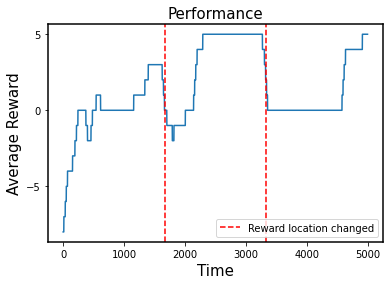

In [ ]:
#-----------------PERFORMANCE PLOT------------------
plot_performance(env_1.get_stored_reward())

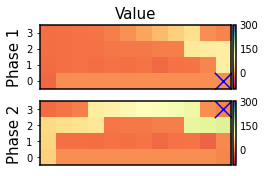

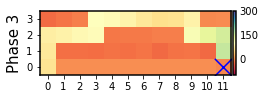

In [ ]:
#-----------------VALUE PLOTS------------------------
plot_values(V_1)

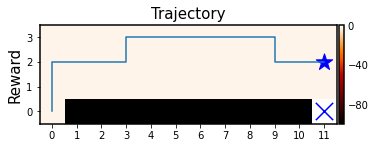

In [ ]:
#-----------------ACTION PLOT-----------------------------
plot_action(agent_1)

Agent 2: Forgetting, Segregates learning 

In [ ]:
# Setup environment
env_2 = gridworld() 

# Intialize Actor-Critic agent
form = 2                                         # Type of agent (Basic, no latent cause inference)
agent_2 = agent(form, eta_v, eta_p, beta)

#-----------------TRAINING--------------------------
env_2, agent_2, V_2 = train(env_2, agent_2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


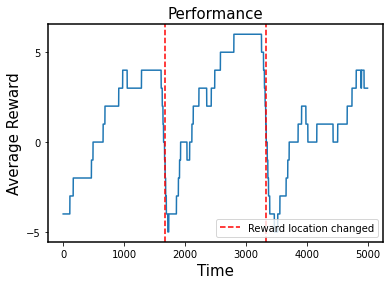

In [ ]:
#-----------------PERFORMANCE PLOT------------------
plot_performance(env_2.get_stored_reward())

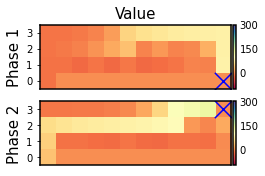

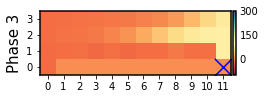

In [ ]:
#-----------------VALUE PLOTS------------------------
plot_values(V_2)

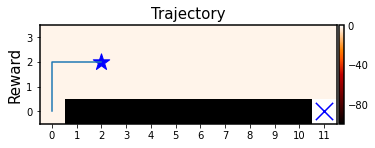

In [ ]:
#-----------------ACTION PLOT-----------------------------
plot_action(agent_2)

Agent 3: Continual learning, can recall old learning

In [ ]:
# Setup environment
env_3 = gridworld() 

# Intialize Actor-Critic agent
form = 3                                         # Type of agent (Basic, no latent cause inference)
agent_3 = agent(form, eta_v, eta_p, beta)

#-----------------TRAINING--------------------------
env_3, agent_3, V_3 = train(env_3, agent_3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


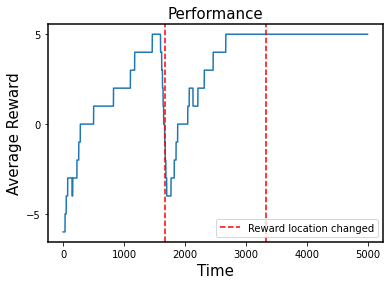

In [ ]:
#-----------------PERFORMANCE PLOT------------------
plot_performance(env_3.get_stored_reward())

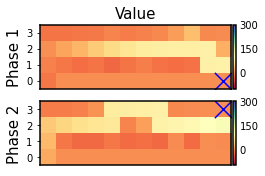

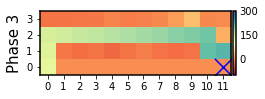

In [ ]:
#-----------------VALUE PLOTS------------------------
plot_values(V_3)

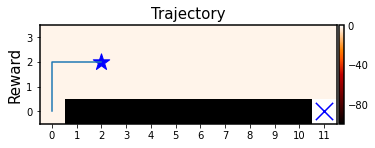

In [ ]:
#-----------------ACTION PLOT-----------------------------
plot_action(agent_3)